Created By: Andy McDonald

The following tutorial illustrates how to calculate key petrophysical properties using pandas

In [45]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

#### PP Equation

In [46]:
import math

def set_limit(low, high, x):
    if x < low:
        return low
    elif x > high:
        return high
    else:
        return x

def log10(x):
    return math.log10(x)

def calc_phit(rhob, rho_grain, rho_fluid):
    phit = (rho_grain - rhob) / (rho_grain - rho_fluid)
    # phit = set_limit(0, 1, phit)
    return phit

def calc_vsh(igr, vsh_gr_method_index):
    if vsh_gr_method_index == 0:
        vsh = igr
    elif vsh_gr_method_index == 1:
        vsh = 0.083 * ((2 ** (3.72 * igr)) - 1)
    elif vsh_gr_method_index == 2:
        vsh = igr / (3 - 2 * igr)
    elif vsh_gr_method_index == 3:
        vsh = 1.7 - ((3.38 - ((igr + 0.7) ** 2)) ** 0.5)
    elif vsh_gr_method_index == 4:
        vsh = 0.33 * ((2 ** (2 * igr)) - 1)
    return vsh

def calc_IGR(gr_log, gr_min, gr_max):
    igr = (gr_log - gr_min) / (gr_max - gr_min)
    return igr

def calculate_volumes(vsh, phit):
    a = 2.252 - 0.7 * phit
    b = 1.04 + 1.5 * phit
    if vsh <= 0.85:
        vsilt = vsh ** (a - 1) * (1 - vsh) ** (b - 1)
    elif 0.85 < vsh <= 0.91:
        vsilt = 0.48
    elif vsh > 0.91:
        vsilt = 5.33 * (1 - vsh)
    else:
        vsilt = 0
    vcld = vsh - vsilt
    return vsilt, vcld

def calc_phie(vsh, phit):
    c0, c1, c2, c3, c4, c5, c6 = 0.0049, -0.0994, 1.47082, -5.545, 11.622, -11.5, 4.553
    swb = (c6 * vsh ** 6 + c5 * vsh ** 5 + c4 * vsh ** 4 + c3 * vsh ** 3 +
           c2 * vsh ** 2 + c1 * vsh + c0)
    phie = phit * (1 - swb)
    return phie

def calc_sw(phit, rt, rw, mstar, nstar, bqv, sw_method_index):
    swt = 0.5
    tolerance = 0.001
    if sw_method_index == 0:
        swt = (phit ** -mstar * rw / rt) ** (1 / nstar)
        swt = set_limit(0, 1, swt)
    else:
        for _ in range(32600):
            cwe = (1 / rw) + bqv / swt
            swt_lhs = (1 / (rt * cwe * (phit ** mstar))) ** (1 / nstar)
            if abs(swt_lhs - swt) > tolerance:
                swt = swt_lhs
            else:
                swt = set_limit(0, 1, swt_lhs)
                break
    return swt

def calc_permeability_choo(clayconst, siltconst, rg, reff, mstar, obg, fpg, avgphit, rdepth, phit, vclw, vsilt):
    nob_ch = rdepth * (obg - fpg)
    alpha_ch = math.exp(nob_ch * 0.00002)
    b1 = 1 / (alpha_ch * avgphit ** mstar)
    b2 = rg / reff
    beta_ch = log10(b1) / log10(b2)
    znagen = (rg ** 2) / (8 * (alpha_ch ** (2 / beta_ch))) / 100
    znaphit = (2 / beta_ch + 1) * mstar
    permchoo = znagen * (phit ** znaphit) / (10 ** (clayconst * vclw + siltconst * vsilt))
    return permchoo

def calc_vwater(phit, phie, swt):
    swe = 1 - ((1 - swt) * phit / phie)
    vhc = (1 - swe) * phie
    vwater = swe * phie
    return vhc, vwater

def calc_choo_shf(tvdss, permchoo, phit, phie, fwl, gw, gh, ift, b0):
    swb = 1 - phie / phit
    hafwl = fwl - tvdss
    if hafwl > 0:
        pc = (gw - gh) * hafwl
        je = 10 ** ((2 * b0 - 1) * log10(1 + (1 / swb)) + log10(1 + swb))
        b = (b0 / 3) * log10(1 + (1 / swb))
        j_de = 0.2166 * pc / ift * ((permchoo / phit) ** 0.5)
        shf = je / (j_de ** b)
        shf = set_limit(0, 1, shf)
    else:
        shf = 1
    return shf


In [47]:
# QC
""" shale_volume(120, 200, 15)
effective_porosity(0.4, 0.3, 0.3)
total_porosity(2.45, 2.65, 1)
sw_archie(0.1, 10, 0.1, 1, 2, 2)
sw_simandoux(0.1, 10, 0.1, 1, 2, 2, 0.3, 2) """

' shale_volume(120, 200, 15)\neffective_porosity(0.4, 0.3, 0.3)\ntotal_porosity(2.45, 2.65, 1)\nsw_archie(0.1, 10, 0.1, 1, 2, 2)\nsw_simandoux(0.1, 10, 0.1, 1, 2, 2, 0.3, 2) '

### Load Data

In [48]:
#Load from LAS
'''
import lasio
import pandas as pd

# Load the LAS file
las = lasio.read("Data/Bekok Deep CSV/BEKOK DEEP-1RDR1 ST1_EDIT_V1.csv")

# Convert LAS data to a DataFrame
well = las.df()

# Display the DataFrame
print(df.head())
'''

'\nimport lasio\nimport pandas as pd\n\n# Load the LAS file\nlas = lasio.read("Data/Bekok Deep CSV/BEKOK DEEP-1RDR1 ST1_EDIT_V1.csv")\n\n# Convert LAS data to a DataFrame\nwell = las.df()\n\n# Display the DataFrame\nprint(df.head())\n'

In [49]:
#Load from CSV
#well = pd.read_csv("Data/Bekok Deep CSV/BEKOK DEEP-1RDR1 ST1_EDIT.csv", header=0, skiprows=[1])
well = pd.read_csv("Data/Bekok Deep CSV/BEKOK DEEP-1RDR1_EDIT.csv", header=0, skiprows=[1])

well.head()

,wellName,datasetName,DEPTH,CALI,DTCO,DTSH,GR,NPHI,RHOB,RT
0,BEKOK DEEP-1RDR1,EDIT,570.631279,13.005373,133.723088,384.465305,80.422127,0.471375,2.226284,2.146416
1,BEKOK DEEP-1RDR1,EDIT,570.783678,12.835868,133.745217,350.501147,73.747749,0.447508,2.247287,2.532999
2,BEKOK DEEP-1RDR1,EDIT,570.936079,12.807315,134.342523,334.622242,70.445236,0.419205,2.238575,2.650963
3,BEKOK DEEP-1RDR1,EDIT,571.088478,12.881797,132.644212,333.516021,72.615990,0.397264,2.212804,2.605329
4,BEKOK DEEP-1RDR1,EDIT,571.240879,12.976698,131.528799,343.370739,75.027985,0.387106,2.189204,2.560487


In [50]:
# Data cleaning
well.replace(-9999.00, np.nan, inplace=True)

well.describe()

,DEPTH,CALI,DTCO,DTSH,GR,NPHI,RHOB,RT
count,17269.000000,17233.000000,15235.000000,15180.000000,17008.000000,16786.000000,16921.000000,17203.000000
mean,1886.452879,11.624918,106.509612,229.766308,102.975354,0.341597,2.436027,7.238059
std,759.755946,1.481624,23.193253,78.047935,43.590933,0.128179,0.175452,16.006676
min,570.631279,8.477599,55.588706,96.561480,19.972311,0.016172,1.253726,0.597107
25%,1228.542079,12.092411,85.582244,153.980963,74.702511,0.260510,2.313120,1.646005
50%,1886.452879,12.164278,106.762528,226.269814,96.193748,0.342011,2.456001,2.170904
75%,2544.363679,12.245284,120.333391,271.577683,115.326664,0.438863,2.598630,5.319799
max,3202.274479,17.962816,205.399899,576.204857,246.149399,1.382609,2.860120,260.393532


(0.0, 250.0)

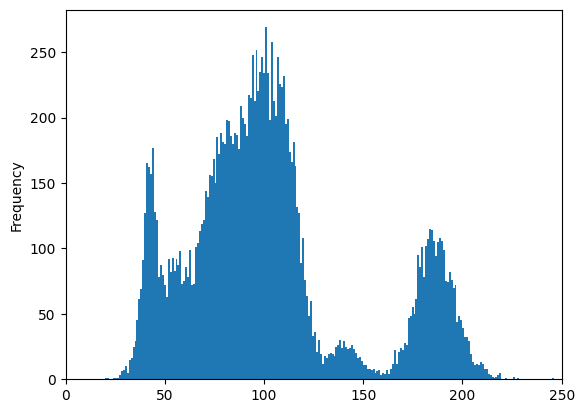

In [51]:
# Data QAQC using histogram
well['GR'].plot(kind='hist', bins=230)
plt.xlim(0, 250)

### Calculate PP Properties

Using the functions created above, we can pass through the required columns in order to calculate the key petrophysical properties

In [52]:
#Calculate IGR

gr_log=well['GR']
gr_min=well['GR'].quantile(q=0.01)
gr_max=well['GR'].quantile(q=0.99)

well['IGR'] = calc_IGR(gr_log, gr_min, gr_max)
well['IGR'] = well['IGR'].apply(lambda x: set_limit(0, 1, x))

In [53]:
#Calculate Shale Volume

well['VSHALE'] = calc_vsh(well["IGR"], 1)
well['VSHALE'] = well['VSHALE'].apply(lambda x: set_limit(0, 1, x))



In [54]:
# Calculate PHIT

rhob=well['RHOB']
rho_grain=2.65
rho_fluid=1

well['PHIT'] = calc_phit(well['RHOB'], 2.65, 1)
well['PHIT'] = well['PHIT'].apply(lambda x: set_limit(0, 1, x))


In [55]:
# Calculate PHIE

well['PHIE'] = calc_phie(well["VSHALE"], well["PHIT"])

In [59]:
# Calculate Volume
well["VSILT"],well["VCLD"]=calculate_volumes(well["VSHALE"], well["PHIT"])


ValueError: The truth value of a Series is ambiguous. Use a.empty, a.bool(), a.item(), a.any() or a.all().

In [60]:
VSHALE

NameError: name 'VSHALE' is not defined

In [145]:
well

,wellName,datasetName,DEPTH,CALI,DTCO,DTSH,GR,NPHI,RHOB,RT,IGR,VSHALE,PHIT,PHIE
0,BEKOK DEEP-1RDR1,EDIT,570.631279,13.005373,133.723088,384.465305,80.422127,0.471375,2.226284,2.146416,0.263461,0.080723,0.256798,0.255771
1,BEKOK DEEP-1RDR1,EDIT,570.783678,12.835868,133.745217,350.501147,73.747749,0.447508,2.247287,2.532999,0.223188,0.064575,0.244068,0.243260
2,BEKOK DEEP-1RDR1,EDIT,570.936079,12.807315,134.342523,334.622242,70.445236,0.419205,2.238575,2.650963,0.203261,0.057183,0.249349,0.248574
3,BEKOK DEEP-1RDR1,EDIT,571.088478,12.881797,132.644212,333.516021,72.615990,0.397264,2.212804,2.605329,0.216359,0.061999,0.264967,0.264111
4,BEKOK DEEP-1RDR1,EDIT,571.240879,12.976698,131.528799,343.370739,75.027985,0.387106,2.189204,2.560487,0.230913,0.067543,0.279270,0.278317
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17264,BEKOK DEEP-1RDR1,EDIT,3201.664879,8.635124,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
17265,BEKOK DEEP-1RDR1,EDIT,3201.817279,8.635124,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
17266,BEKOK DEEP-1RDR1,EDIT,3201.969679,8.635124,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
17267,BEKOK DEEP-1RDR1,EDIT,3202.122079,8.635124,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [146]:
well.describe()

,DEPTH,CALI,DTCO,DTSH,GR,NPHI,RHOB,RT,IGR,VSHALE,PHIT,PHIE
count,17269.000000,17233.000000,15235.000000,15180.000000,17008.000000,16786.000000,16921.000000,17203.000000,17008.000000,17008.000000,16921.000000,16899.000000
mean,1886.452879,11.624918,106.509612,229.766308,102.975354,0.341597,2.436027,7.238059,0.399382,0.219060,0.130186,0.128463
std,759.755946,1.481624,23.193253,78.047935,43.590933,0.128179,0.175452,16.006676,0.261860,0.257850,0.105627,0.106060
min,570.631279,8.477599,55.588706,96.561480,19.972311,0.016172,1.253726,0.597107,0.000000,0.000000,0.000000,0.000000
25%,1228.542079,12.092411,85.582244,153.980963,74.702511,0.260510,2.313120,1.646005,0.228949,0.066783,0.031133,0.026385
50%,1886.452879,12.164278,106.762528,226.269814,96.193748,0.342011,2.456001,2.170904,0.358625,0.126256,0.117575,0.116752
75%,2544.363679,12.245284,120.333391,271.577683,115.326664,0.438863,2.598630,5.319799,0.474072,0.198811,0.204169,0.203313
max,3202.274479,17.962816,205.399899,576.204857,246.149399,1.382609,2.860120,260.393532,1.000000,1.000000,0.846227,0.842080


### Plot Display

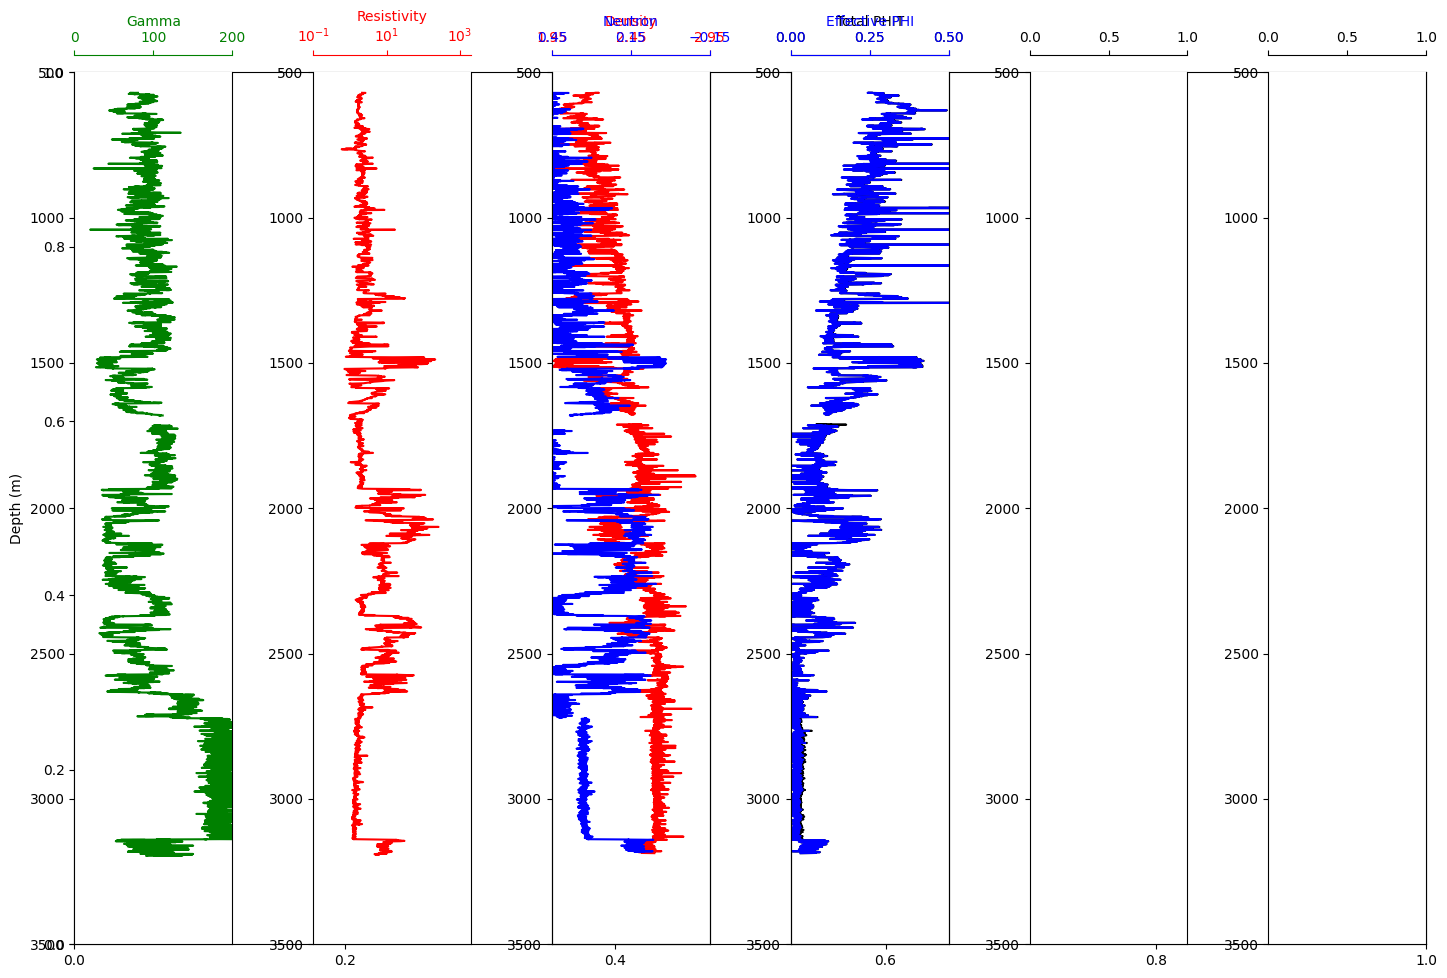

In [44]:
fig, ax = plt.subplots(figsize=(15,10))

#Set up the plot axes
ax1 = plt.subplot2grid((1,6), (0,0), rowspan=1, colspan = 1)
ax2 = plt.subplot2grid((1,6), (0,1), rowspan=1, colspan = 1)
ax3a = plt.subplot2grid((1,6), (0,2), rowspan=1, colspan = 1)
ax3b = ax3a.twiny() #Twins the y-axis for the density track with the neutron track
ax4a = plt.subplot2grid((1,6), (0,3), rowspan=1, colspan = 1)
ax4b = ax4a.twiny()
ax5 = plt.subplot2grid((1,6), (0,4), rowspan=1, colspan = 1)
ax6 = plt.subplot2grid((1,6), (0,5), rowspan=1, colspan = 1)


# Gamma Ray track
ax1.plot("GR", "DEPTH", data = well, color = "green")
ax1.set_xlabel("Gamma")
ax1.xaxis.label.set_color("green")
ax1.set_xlim(0, 200)
ax1.set_ylabel("Depth (m)")
ax1.tick_params(axis='x', colors="green")
ax1.spines["top"].set_edgecolor("green")
ax1.title.set_color('green')
ax1.set_xticks
([0, 50, 100, 150, 200])

# Resistivity track
ax2.plot("RT", "DEPTH", data = well, color = "red")
ax2.set_xlabel("Resistivity")
ax2.set_xlim(0.2, 2000)
ax2.xaxis.label.set_color("red")
ax2.tick_params(axis='x', colors="red")
ax2.spines["top"].set_edgecolor("red")
ax2.set_xticks([0.1, 1, 10, 100, 1000])
ax2.semilogx()

# Density track
ax3a.plot("RHOB", "DEPTH", data = well, color = "red")
ax3a.set_xlabel("Density")
ax3a.set_xlim(1.95, 2.95)
ax3a.xaxis.label.set_color("red")
ax3a.tick_params(axis='x', colors="red")
ax3a.spines["top"].set_edgecolor("red")
ax3a.set_xticks([1.95, 2.45, 2.95])

# Neutron track placed ontop of density track
ax3b.plot("NPHI", "DEPTH", data = well, color = "blue")
ax3b.set_xlabel('Neutron')
ax3b.xaxis.label.set_color("blue")
ax3b.set_xlim(0.45, -0.15)
ax3b.set_ylim(4150, 3500)
ax3b.tick_params(axis='x', colors="blue")
ax3b.spines["top"].set_position(("axes", 1.08))
ax3b.spines["top"].set_visible(True)
ax3b.spines["top"].set_edgecolor("blue")
ax3b.set_xticks([0.45,  0.15, -0.15])

# Porosity track
ax4a.plot("PHIT", "DEPTH", data = well, color = "black")
ax4a.set_xlabel("Total PHIT")
ax4a.set_xlim(0, 0.5)
ax4a.xaxis.label.set_color("black")
ax4a.tick_params(axis='x', colors="black")
ax4a.spines["top"].set_edgecolor("black")
ax4a.set_xticks([0, 0.25, 0.5])

# Porosity track
ax4b.plot("PHIE", "DEPTH", data = well, color = "blue")
ax4b.set_xlabel("Effective PHI")
ax4b.set_xlim(0, 0.5)
ax4b.xaxis.label.set_color("blue")
ax4b.tick_params(axis='x', colors="blue")
ax4b.spines["top"].set_position(("axes", 1.08))
ax4b.spines["top"].set_visible(True)
ax4b.spines["top"].set_edgecolor("blue")
ax4b.set_xticks([0, 0.25, 0.5])

# #Permeability track
# ax5.plot("PERM_KOZENY", "DEPTH", data = well, color = "red")
# ax5.set_xlabel("Perm Kozeny")
# ax5.set_xlim(0.1, 1000)
# ax5.xaxis.label.set_color("red")
# ax5.tick_params(axis='x', colors="red")
# ax5.spines["top"].set_edgecolor("red")
# ax5.set_xticks([0.1, 1, 10, 100, 1000])

# # Sw track
# ax6.plot("SW_LIM", "DEPTH", data = well, color = "black")
# ax6.set_xlabel("SW - Archie")
# ax6.set_xlim(0, 1)
# ax6.xaxis.label.set_color("black")
# ax6.tick_params(axis='x', colors="black")
# ax6.spines["top"].set_edgecolor("black")
# ax6.set_xticks([0, 0.5, 1])



for ax in [ax1, ax2, ax3a ,ax3b,ax4a,ax4b, ax5, ax6 ]:
# for ax in [ax1, ax2, ax3a ,ax4a,ax5, ax6]:
    ax.set_ylim(3500, 500)
    # ax.set_ylim(1350, 1250)
    #ax.grid(which='major', color='lightgrey', linestyle='-')
    ax.xaxis.set_ticks_position("top")
    ax.xaxis.set_label_position("top")
    ax.spines["top"].set_position(("axes", 1.02))

plt.tight_layout()
